In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Parsing FASTA File

In [2]:
def parse_fasta(file_path):
    sequences = []
    with open(file_path, 'r') as file:
        content = file.read().strip()

    # Split the content by the '>' character, which marks the start of a new sequence
    entries = content.split('>')
    
    for entry in entries:
        if entry:
            # Split each entry into lines
            lines = entry.split('\n')
            # The first line is the header
            header = lines[0].strip()
            # The remaining lines are the sequence
            sequence = ''.join(lines[1:]).strip()
            # Append the header and sequence to the list as a tuple
            sequences.append((header, sequence.upper()))
    
    return sequences

In [3]:
# load sequence/FASTA data
sequences = parse_fasta('/Users/sham/Desktop/Dr. Hanson Research/DataSets/Candida Arabinofermentans/ncbi_dataset/ncbi_dataset/data/GCA_001661425.1/GCA_001661425.1_Canar1_genomic.fna')
# load GTF data
GTF_df = pd.read_csv('/Users/sham/Desktop/Dr. Hanson Research/DataSets/Candida Arabinofermentans/ncbi_dataset/ncbi_dataset/data/GCA_001661425.1/genomic.gtf', sep='\t', comment='#', header=None)

# get chr_ids
chr_ids = GTF_df[0].unique()

In [77]:
miss_per_chr = 0
loss = 0

for n in range(len(sequences)):
    miss_per_chr = 0
    # print(n)
    for i in sequences[n][1]:
        if i not in ['A','T','G','C']:
            # print(i)
            miss_per_chr += 1
    # print(miss_per_chr / len(sequences[n][1]))
    loss += miss_per_chr/len(sequences[n][1])
            
print(loss / len(sequences) * 100)
print(loss / len(sequences))

3.2329959715230916
0.032329959715230915


In [4]:
def complement_seq(seq):
    seq_list = list(seq)

    for i in range(len(seq_list)):
        if seq_list[i] == 'A':
            seq_list[i] = 'T'
        elif seq_list[i] == 'T':
            seq_list[i] = 'A'
        elif seq_list[i] == 'G':
            seq_list[i] = 'C'
        else:
            seq_list[i] = 'G'
    return ''.join(seq_list)

In [47]:
# reset indexing
def reset_df(df):
    out_df = df.reset_index()
    out_df = out_df.drop('index', axis=1)
    return out_df

# Get gene and CDS data only
GTF_gene_and_cds = GTF_df[GTF_df[2].isin(['CDS', 'gene'])]
GTF_gene_and_cds = reset_df(GTF_gene_and_cds)

def get_GTF_by_chr_gene_cds_only(chr_ids, GTF):
    GTF_dict = {}
    for id in chr_ids:
        processed_GTF = reset_df(GTF[GTF[0] == id])
        GTF_dict[id] = processed_GTF
    
    return GTF_dict

def get_all_seq_per_chr_ids(sequences, chr_ids):
    out_dict = {}
    for i in sequences:
        if i[0][:10] in chr_ids:
            stri = str(''.join(i[1]))
            out_dict[i[0][:10]] = stri
    return out_dict

GTF_by_chr_gene_cds_dict = get_GTF_by_chr_gene_cds_only(chr_ids, GTF_gene_and_cds)
sequences_by_ids_dict = get_all_seq_per_chr_ids(sequences, chr_ids)

In [48]:
GTF_df[:10]

,0,1,2,3,4,5,6,7,8
0,KV453847.1,Genbank,gene,617,688,.,+,.,"gene_id ""CANARDRAFT_t1""; transcript_id """"; gbk..."
1,KV453847.1,Genbank,transcript,617,688,.,+,.,"gene_id ""CANARDRAFT_t1""; transcript_id ""unassi..."
2,KV453847.1,Genbank,exon,617,688,.,+,.,"gene_id ""CANARDRAFT_t1""; transcript_id ""unassi..."
3,KV453847.1,Genbank,gene,813,4178,.,-,.,"gene_id ""CANARDRAFT_25881""; transcript_id """"; ..."
4,KV453847.1,Genbank,transcript,813,4178,.,-,.,"gene_id ""CANARDRAFT_25881""; transcript_id ""gnl..."
5,KV453847.1,Genbank,exon,813,4178,.,-,.,"gene_id ""CANARDRAFT_25881""; transcript_id ""gnl..."
6,KV453847.1,Genbank,CDS,869,4054,.,-,0,"gene_id ""CANARDRAFT_25881""; transcript_id ""gnl..."
7,KV453847.1,Genbank,start_codon,4052,4054,.,-,0,"gene_id ""CANARDRAFT_25881""; transcript_id ""gnl..."
8,KV453847.1,Genbank,stop_codon,866,868,.,-,0,"gene_id ""CANARDRAFT_25881""; transcript_id ""gnl..."
9,KV453847.1,Genbank,gene,4411,6369,.,-,.,"gene_id ""CANARDRAFT_209915""; transcript_id """";..."


In [62]:
def get_cds_gene_idx(seq, gtf):
    
    # list of indexes list that have the strand info and all the cds indexes of a gene
    # example: [['+', 1], ['-', 3, 4, 5], ['-', 7, 8, 9, 10], ['+', 12], ['+', 14], ...]
    gene_cds_idx = []
    ind_idx = ['x']
    for i in range(1, len(gtf)):
        if (gtf.iloc[i,2] != 'gene'):
            ind_idx.append(i)
            ind_idx[0] = gtf.iloc[i,6]
        elif (gtf.iloc[i,2] == 'gene'):
            gene_cds_idx.append(ind_idx)
            ind_idx = ['x']
    gene_cds_idx.append(ind_idx)

    gene_cds_sequences = []
    for cds_range in gene_cds_idx:
        seq_str = ''
        frame_skip = 0
        if cds_range[0] == '+':
            for idx in cds_range[1:]:
                frame_skip = int(gtf.iloc[idx,7])
                seq_str += seq[gtf.iloc[idx,3]-1+frame_skip : gtf.iloc[idx,4]]
                frame_skip = 0
            gene_cds_sequences.append(seq_str)
        elif cds_range[0] == '-':
            for idx in cds_range[1:]:
                frame_skip = int(gtf.iloc[idx,7])
                seq_str += complement_seq(seq[gtf.iloc[idx,3]-1 : gtf.iloc[idx,4]-frame_skip])[::-1]
                frame_skip = 0
            gene_cds_sequences.append(seq_str)
    
    return gene_cds_sequences


def calc_gc3_pct(gene_seqs, window):
    pct_arr = []
    for seq in gene_seqs:
        codon3_ct = 0
        gc3_ct = 0
        for i in range(2,len(seq),3):
            if (seq[i] == 'G' or seq[i] == 'C'):
                gc3_ct += 1
            codon3_ct += 1
        pct_arr.append((gc3_ct / codon3_ct) * 100)
    
    window_pct_arr = []
    for i in range(len(pct_arr)-window+1):
        window_range = pct_arr[i:i + window]
        window_avg = sum(window_range) / window
        window_pct_arr.append(window_avg)
    
    return window_pct_arr

def get_gc3_pcts_by_chr(seq_dict, gtf_dict, win_size):
    gc3_by_pcts_by_chr_dict = {}
    for key in gtf_dict.keys():
        # print(key) ##____________delete later
        # idx_step = get_cds_gene_idx(seq_dict[val], gtf_dict[val])

        gc3_by_pcts_by_chr_dict[key] = calc_gc3_pct(get_cds_gene_idx(seq_dict[key], gtf_dict[key]), win_size)
    return gc3_by_pcts_by_chr_dict

In [63]:
gc3_pcts_by_chrs_dict = get_gc3_pcts_by_chr(sequences_by_ids_dict, GTF_by_chr_gene_cds_dict, win_size=30)

In [65]:
print(get_gc3_pcts_by_chr['KV453847.1'])

dict_keys(['KV453847.1', 'KV453848.1', 'KV453849.1', 'KV453850.1', 'KV453851.1', 'KV453852.1', 'KV453853.1', 'KV453854.1', 'KV453855.1', 'KV453856.1', 'KV453857.1', 'KV453858.1', 'KV453859.1', 'KV453860.1', 'KV453861.1', 'KV453862.1', 'KV453863.1', 'KV453864.1', 'KV453865.1', 'KV453866.1', 'KV453867.1', 'KV453868.1', 'KV453869.1', 'KV453870.1', 'KV453871.1', 'KV453872.1', 'KV453873.1', 'KV453874.1', 'KV453875.1', 'KV453876.1', 'KV453877.1', 'KV453878.1', 'KV453879.1', 'KV453880.1', 'KV453881.1', 'KV453882.1', 'KV453883.1', 'KV453884.1', 'KV453885.1', 'KV453886.1', 'KV453887.1', 'KV453888.1', 'KV453889.1', 'KV453890.1', 'KV453891.1', 'KV453893.1', 'KV453894.1', 'KV453895.1', 'KV453897.1', 'KV453898.1', 'KV453902.1', 'KV453903.1'])


In [74]:
for key in gc3_pcts_by_chrs_dict.keys():
    print(len(gc3_pcts_by_chrs_dict[key]))

662
549
456
426
428
275
214
219
176
183
134
139
124
117
106
96
82
45
67
53
44
32
30
32
19
17
12
1
14
1
6
7
5
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


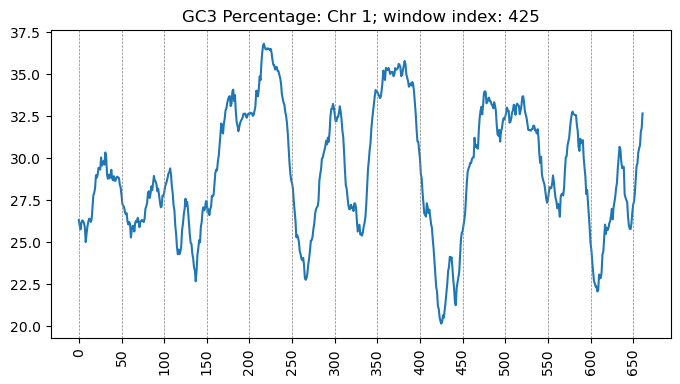

In [70]:
plt.figure(figsize=(8, 4))
plt.plot(list(gc3_pcts_by_chrs_dict['KV453847.1']))

# Title with the location of minimum GC3 percentage
plt.title('GC3 Percentage: Chr 1; window index: ' + str(gc3_pcts_by_chrs_dict['KV453847.1'].index(min(gc3_pcts_by_chrs_dict['KV453847.1']))))

# Setting the y-axis limits and ticks
plt.ylim(35, 50)
plt.yticks([35, 40, 45, 50])

# Adding horizontal lines at y-tick positions
for y in [35, 40, 45, 50]:
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.5)

# Adding x-ticks every 50 intervals
xticks = range(0, len(gc3_pcts_by_chrs_dict['KV453847.1']), 50)
plt.xticks(xticks, rotation=90)  # Rotating x-ticks vertically

# Adding vertical lines at each x-tick
for x in xticks:
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)

plt.show()

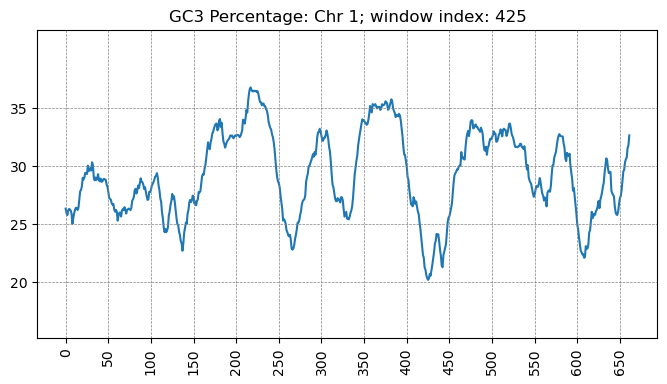

In [72]:
# Sample data for demonstration (replace with your actual data)
gc3_pcts = list(gc3_pcts_by_chrs_dict['KV453847.1'])

plt.figure(figsize=(8, 4))
plt.plot(gc3_pcts)

# Title with the location of minimum GC3 percentage
min_gc3_index = gc3_pcts.index(min(gc3_pcts))
plt.title('GC3 Percentage: Chr 1; window index: ' + str(min_gc3_index))

# Setting the y-axis limits based on data
plt.ylim(min(gc3_pcts) - 5, max(gc3_pcts) + 5)
plt.yticks(range(int(min(gc3_pcts) // 5) * 5, int(max(gc3_pcts) // 5 + 1) * 5, 5))

# Adding horizontal lines at y-tick positions
for y in plt.yticks()[0]:  # Get current y-tick positions
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.5)

# Adding x-ticks dynamically every 50 intervals
xticks = range(0, len(gc3_pcts), 50)
plt.xticks(xticks, rotation=90)

# Adding vertical lines at each x-tick
for x in xticks:
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)

plt.show()



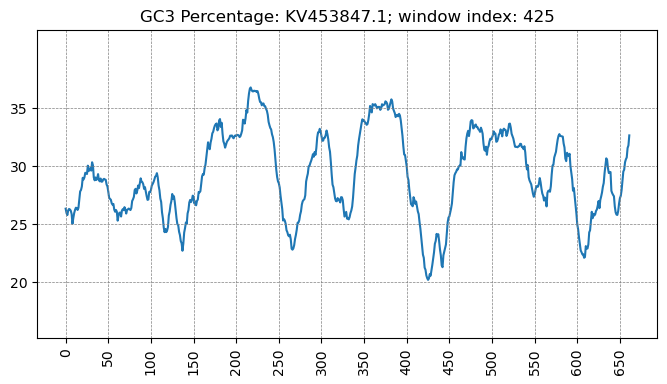

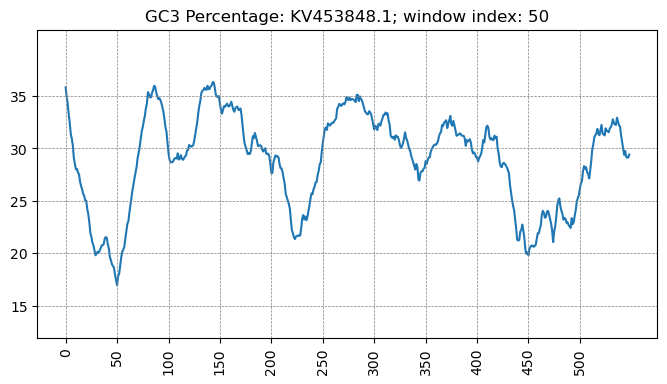

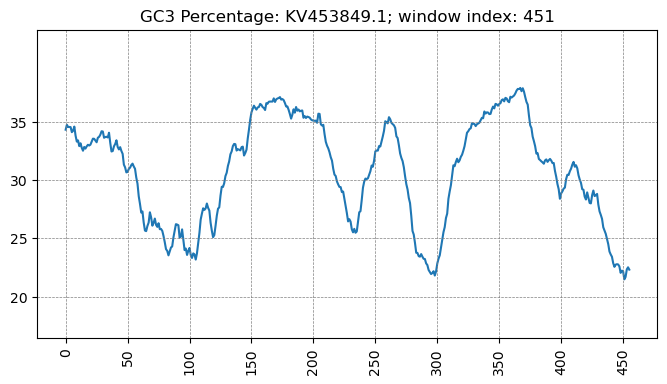

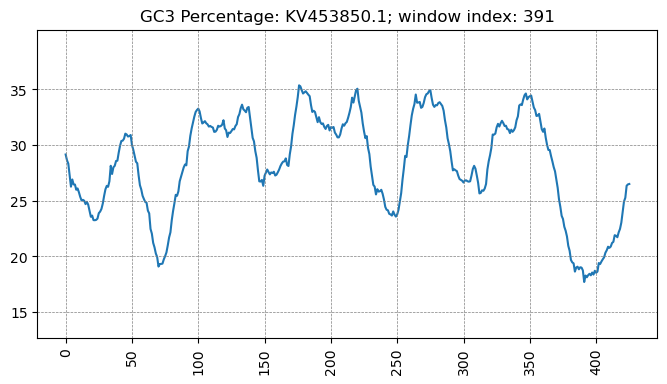

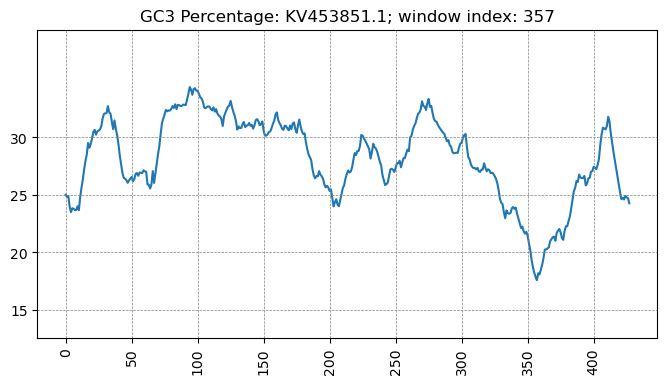

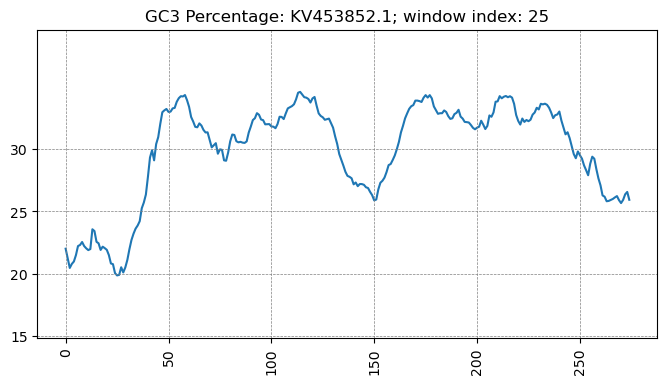

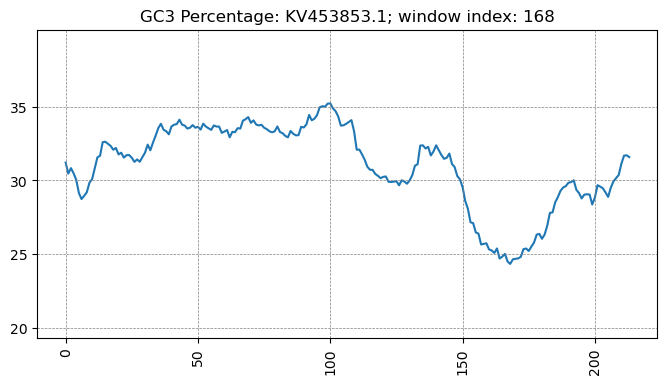

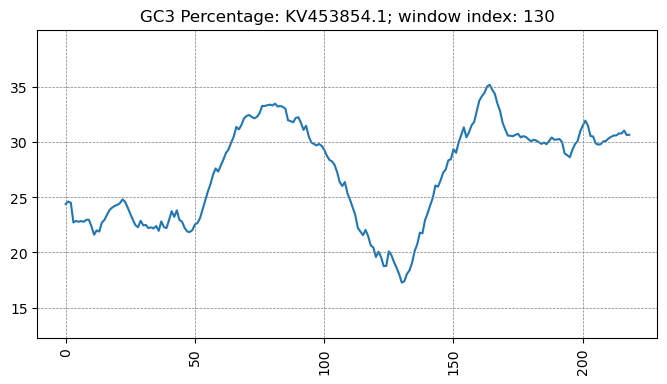

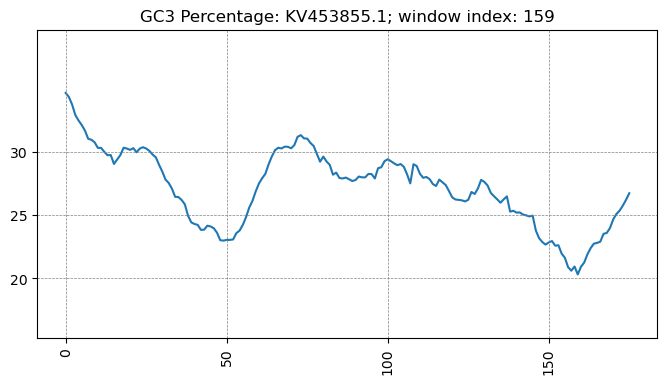

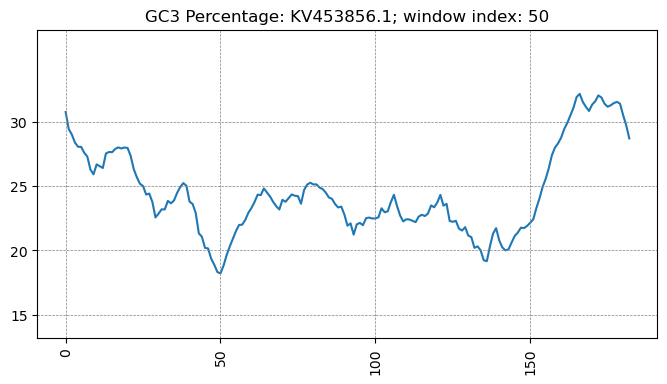

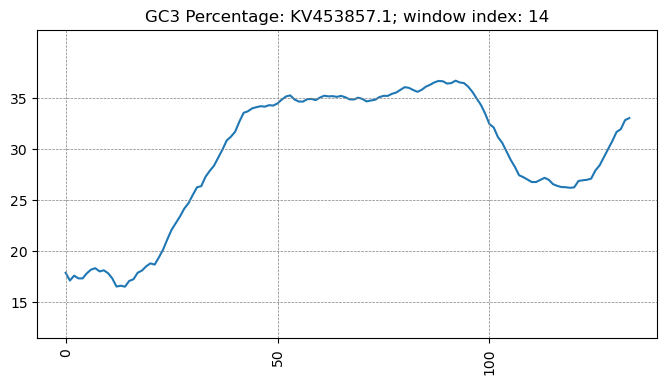

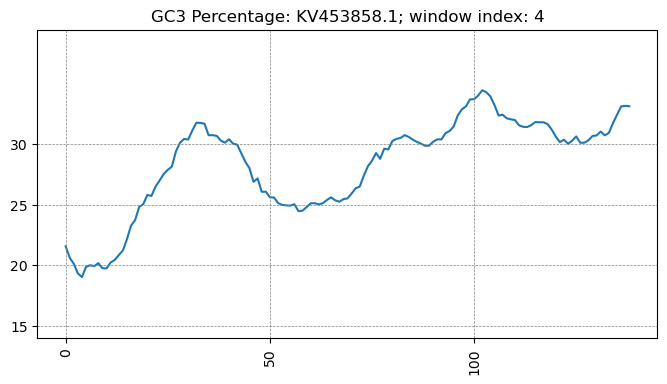

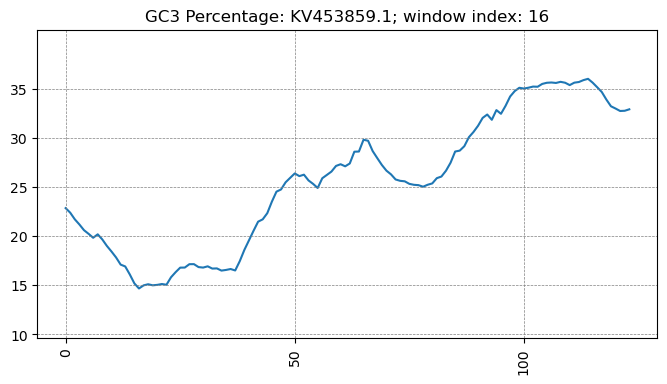

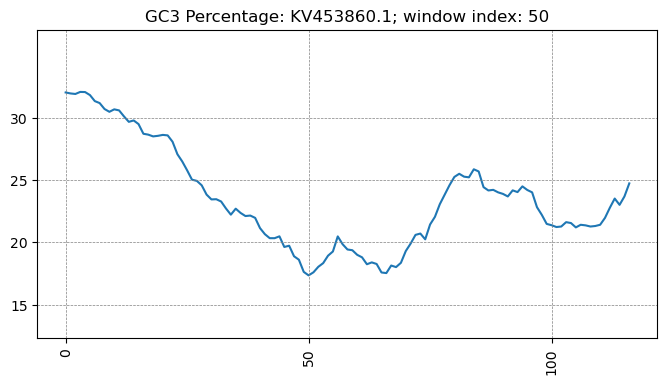

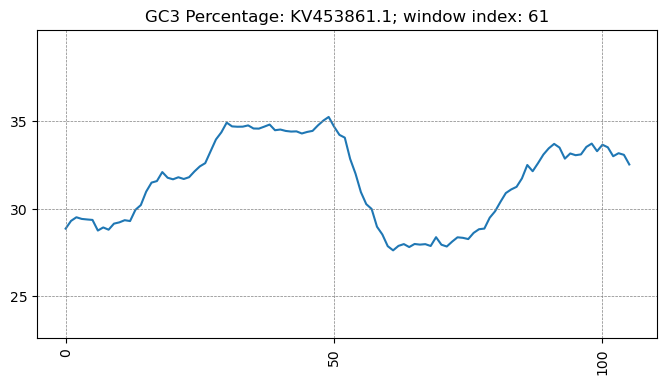

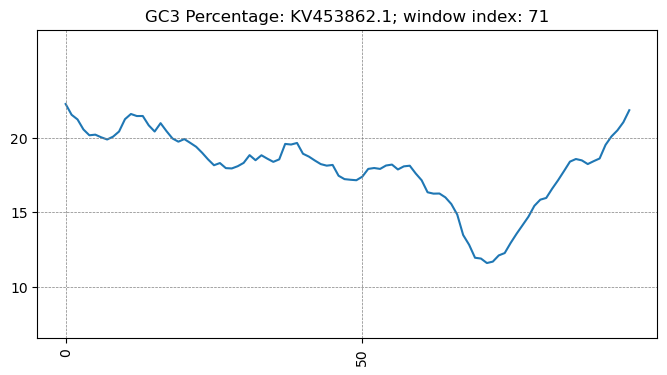

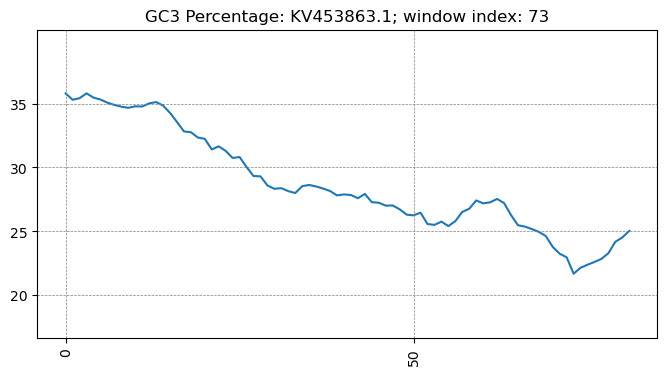

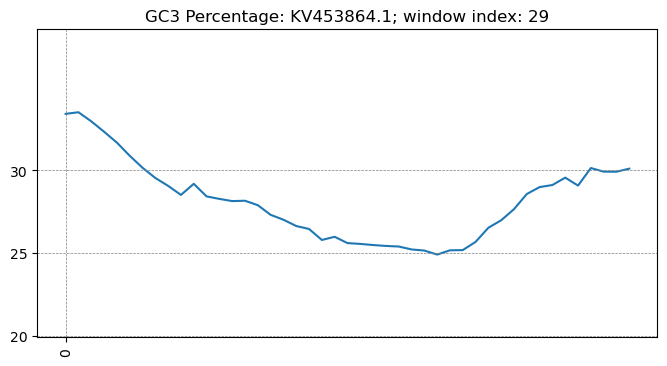

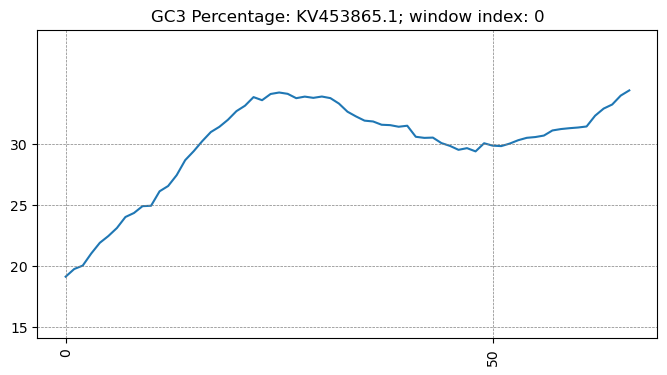

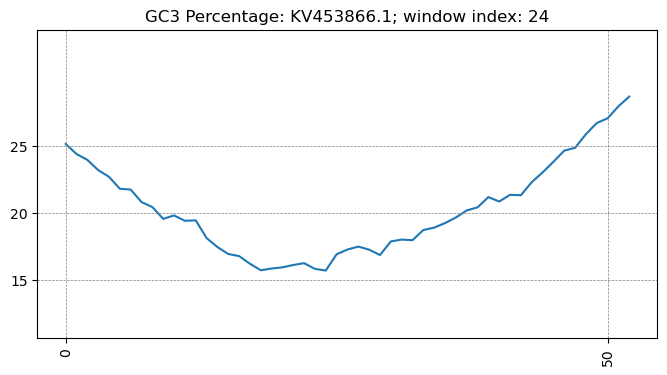

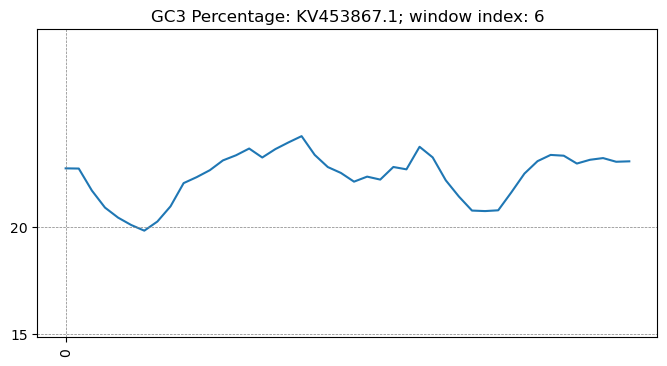

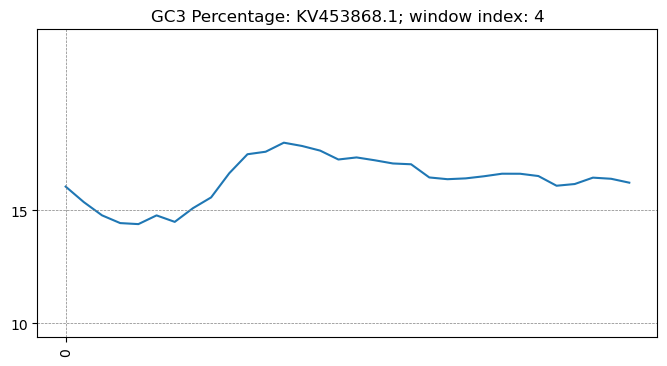

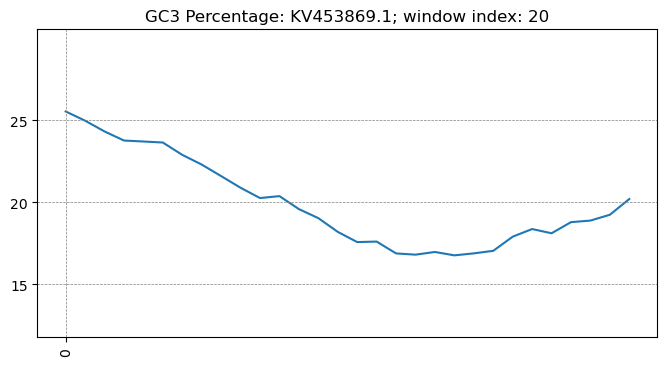

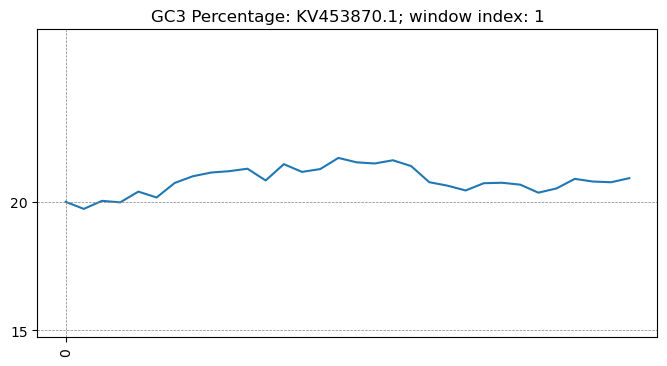

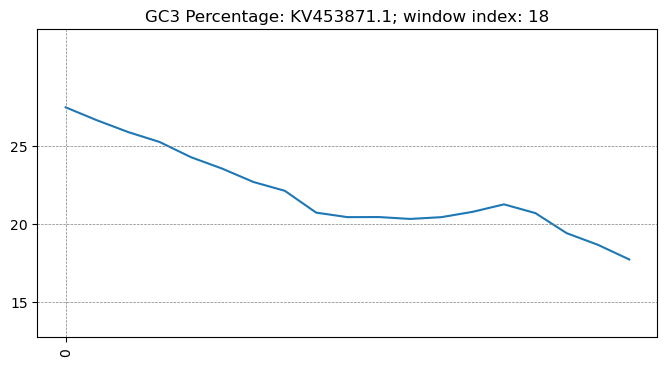

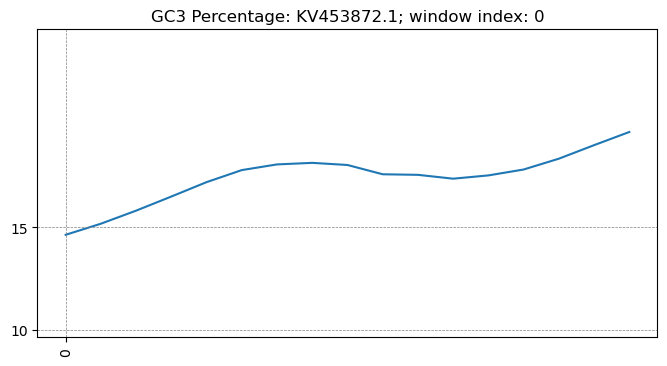

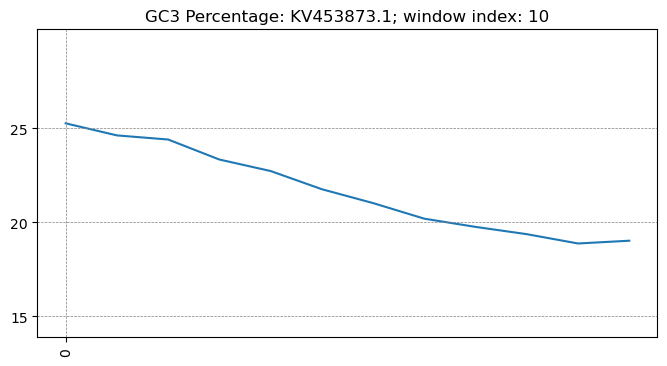

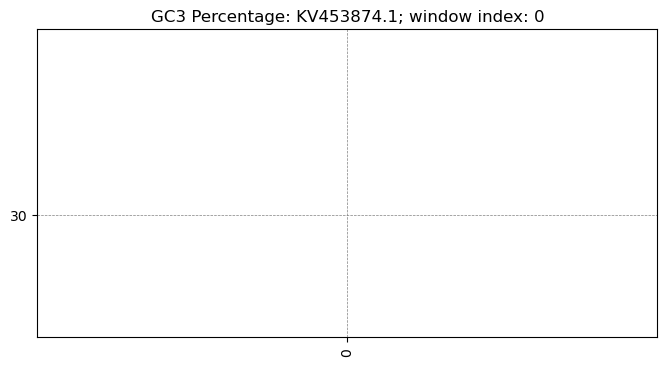

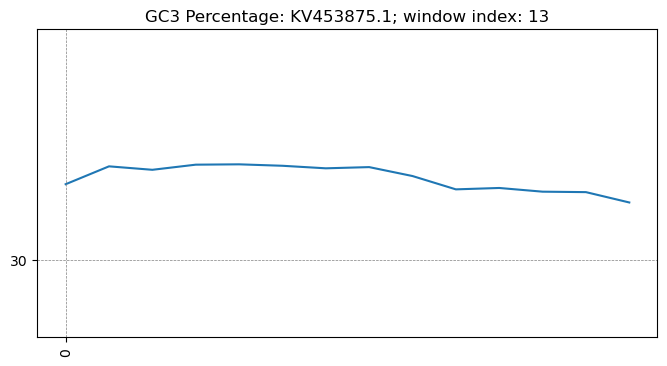

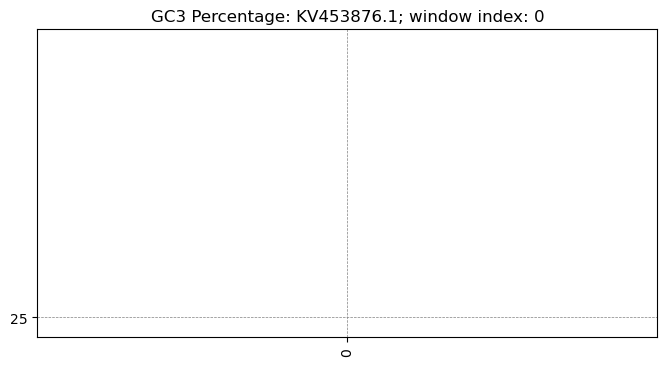

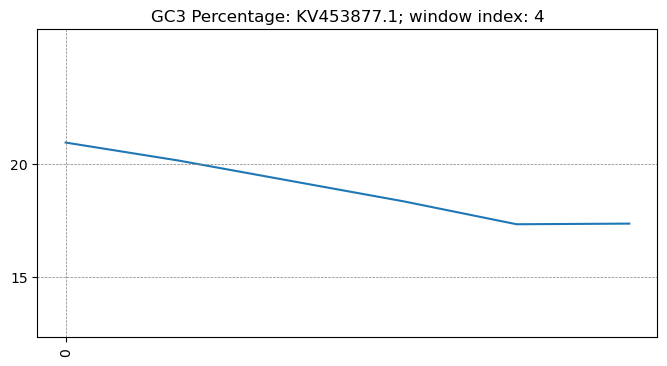

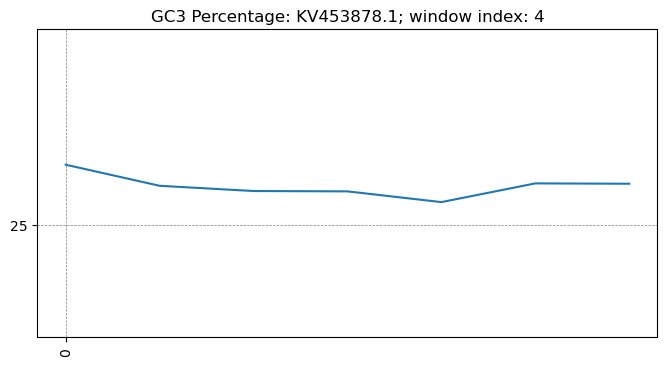

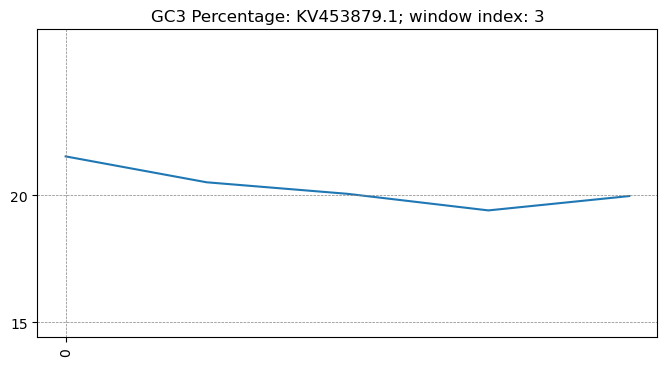

ValueError: min() arg is an empty sequence

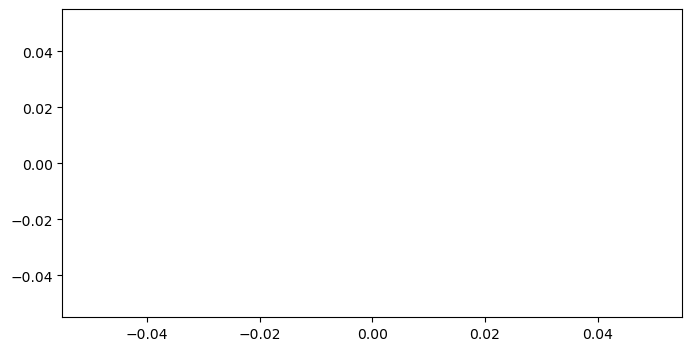

In [73]:
import matplotlib.pyplot as plt

# Loop through each chromosome key in the dictionary
for key in gc3_pcts_by_chrs_dict.keys():
    gc3_pcts = list(gc3_pcts_by_chrs_dict[key])
    
    plt.figure(figsize=(8, 4))
    plt.plot(gc3_pcts)

    # Title with the location of minimum GC3 percentage
    min_gc3_index = gc3_pcts.index(min(gc3_pcts))
    plt.title(f'GC3 Percentage: {key}; window index: {min_gc3_index}')

    # Setting the y-axis limits based on data
    plt.ylim(min(gc3_pcts) - 5, max(gc3_pcts) + 5)
    plt.yticks(range(int(min(gc3_pcts) // 5) * 5, int(max(gc3_pcts) // 5 + 1) * 5, 5))

    # Adding horizontal lines at y-tick positions
    for y in plt.yticks()[0]:  # Get current y-tick positions
        plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.5)

    # Adding x-ticks dynamically every 50 intervals
    xticks = range(0, len(gc3_pcts), 50)
    plt.xticks(xticks, rotation=90)

    # Adding vertical lines at each x-tick
    for x in xticks:
        plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)

    plt.show()  # Show the plot for the current key
